In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
# Read the data
X_full = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [3]:
X_train

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Ex,TA,PConc,Ex,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,New,Partial,20,90.0,11694,9,5,2007,2007,452.0,48,0,1774,1822,1828,0,0,1828,0,0,2,0,3,1,9,1,2007.0,3,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,1Fam,1Story,Hip,CompShg,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,N,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,6600,5,5,1962,1962,0.0,0,0,894,894,894,0,0,894,0,0,1,0,2,1,5,0,1962.0,1,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,None,TA,Gd,BrkTil,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,30,80.0,13360,5,7,1921,2006,0.0,713,0,163,876,964,0,0,964,1,0,1,0,2,1,5,0,1921.0,2,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,NaN,13265,8,5,2002,2002,148.0,1218,0,350,1568,1689,0,0,1689,1,0,2,0,3,1,7,2,2002.0,3,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,118.0,13704,7,5,2001,2002,150.0,0,0,1541,1541,1541,0,0,1541,0,0,2,0,3,1,6,1,2001.0,3,843,468,81,0,0,0,0,0,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60,82.0,9430,8,5,1999,1999,673.0,1163,0,89,1252,1268,1097,0,2365,1,0,2,1,3,1,8,1,1999.0,3,856,0,128,0,0,180,0,0,7,2009
836,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,None,TA,TA,CBlock,Gd,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,Gd,Min2,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20,60.0,9600,4,7,1950,1995,0.0,442,0,625,1067,1067,0,0,1067,0,0,2,0,2,1,4,0,1996.0,2,436,290,0,0,0,0,0,0,2,2010
1217,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,RRAe,Norm,Duplex,1.5Fin,Gable,CompShg,None,TA,TA,Slab,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal,90,68.0,8930,6,5,1978,1978,0.0,0,0,0,0,1318,584,0,1902,0,0,2,0,4,2,8,0,1978.0,2,539,0,0,0,0,0,0,0,4,2010


Next, we will use imputation transformer from scikit-learn for completing missing values. If the strategy used is “constant”, then it replace missing values with fixed value, and by default is zero.

Then follow by ColumnTransformer that applies transformers to columns of an array or pandas DataFrame, it is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms

Another important thing is the pipeline. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [5]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17861.780102739725


We duplicated the code from above but replace the strategy with constant and see if the MAE is get better.

In [6]:
# Preprocessing for categorical data
categorical_transformer_v2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')), #let see if strategy constant will have better result
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer_v2, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17621.3197260274


The MAE is slightly better!

In [0]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

In [8]:
preds_test

array([127168.41, 154869.75, 182907.65, ..., 148173.16, 109054.33,
       226853.  ])

In [0]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_updated_imputation_pipeline_20042020.csv', index=False)

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

![alt text](https://i.imgur.com/9k60cVA.png)

In [13]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X_full, y,cv=5, scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [17715.1285274  17496.14489726 17863.4719863  16211.53356164
 19197.65777397]


In [14]:
print("MAE scores:\n", scores.mean())

MAE scores:
 17696.78734931507


In [15]:
# Let's use numerical data only
cv_numeric_cols = [cname for cname in X_full.columns if X_full[cname].dtype in ['int64', 'float64']]
numerical_X = X_full[cv_numeric_cols].copy()
numerical_X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010


Lastly, we try to find out the optimum estimator number for the Random Forest regressor with 3-fold cross-validation.

In [0]:
def get_score(n_estimators):
    cv_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])

    scores = -1 * cross_val_score(cv_pipeline, numerical_X, y, cv=3, scoring='neg_mean_absolute_error')
    
    return scores.mean()

In [0]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

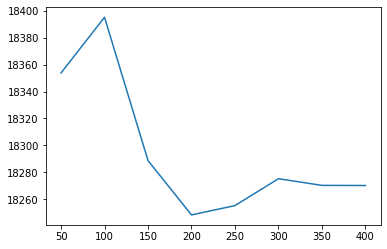

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [20]:
min_values = min(results.values())
min_estimator_num = [key for key in results if results[key] == min_values]
min_estimator_num[0]

200

From the result, we can see that 200 estimator for the forest is the optimum as it get lowest MAE scores.